In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import ast

from base64 import b64decode
from collections import Counter

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

<IPython.core.display.Javascript object>

In [3]:
from tqdm.notebook import tqdm

<IPython.core.display.Javascript object>

In [4]:
import pycode_similar
from pyastsim.pyastsim import NormFunctions, NormIdentifiers, astunparse, editdistance

<IPython.core.display.Javascript object>

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
import warnings

warnings.filterwarnings("ignore")  # UMAP numba

<IPython.core.display.Javascript object>

In [6]:
from IPython.display import display, HTML, Markdown

<IPython.core.display.Javascript object>

In [7]:
np.random.seed(42)

<IPython.core.display.Javascript object>

In [8]:
!ls ../data

umimeprogramovatcz-ipython_item.csv	 umimeprogramovatcz-ipython_log.csv
umimeprogramovatcz-ipython_item_log.csv


<IPython.core.display.Javascript object>

In [9]:
ip_log_frame = pd.read_csv("../data/umimeprogramovatcz-ipython_log.csv", sep=";")
ip_item_frame = pd.read_csv("../data/umimeprogramovatcz-ipython_item.csv", sep=";")
ip_item_log_frame = pd.read_csv(
    "../data/umimeprogramovatcz-ipython_item_log.csv", sep=";"
)

<IPython.core.display.Javascript object>

In [10]:
ip_log_frame.shape, ip_item_frame.shape, ip_item_log_frame.shape

((43615, 8), (74, 11), (4164, 7))

<IPython.core.display.Javascript object>

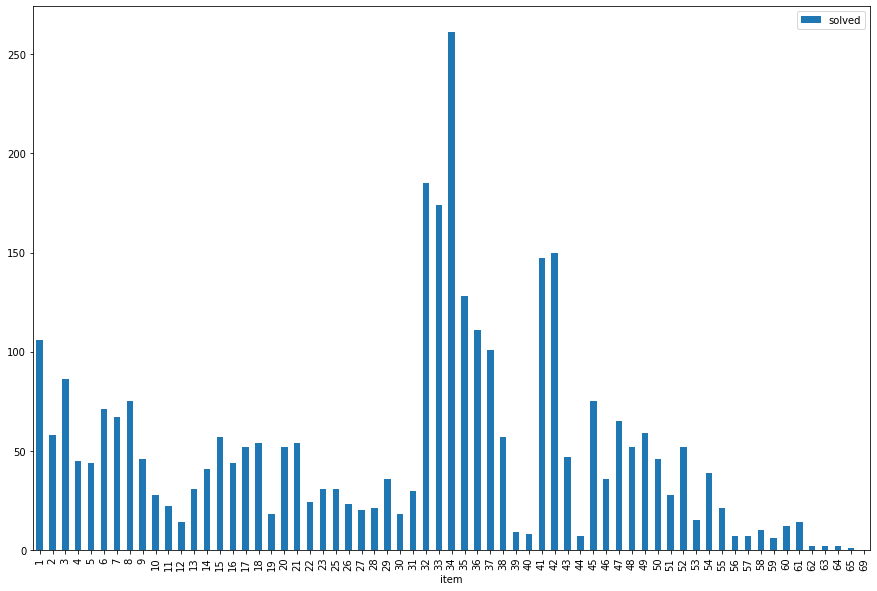

<IPython.core.display.Javascript object>

In [11]:
ip_item_log_frame.groupby("item").sum().reset_index()[["item", "solved"]].plot.bar(
    x="item", y="solved", figsize=(15, 10)
)
plt.show()

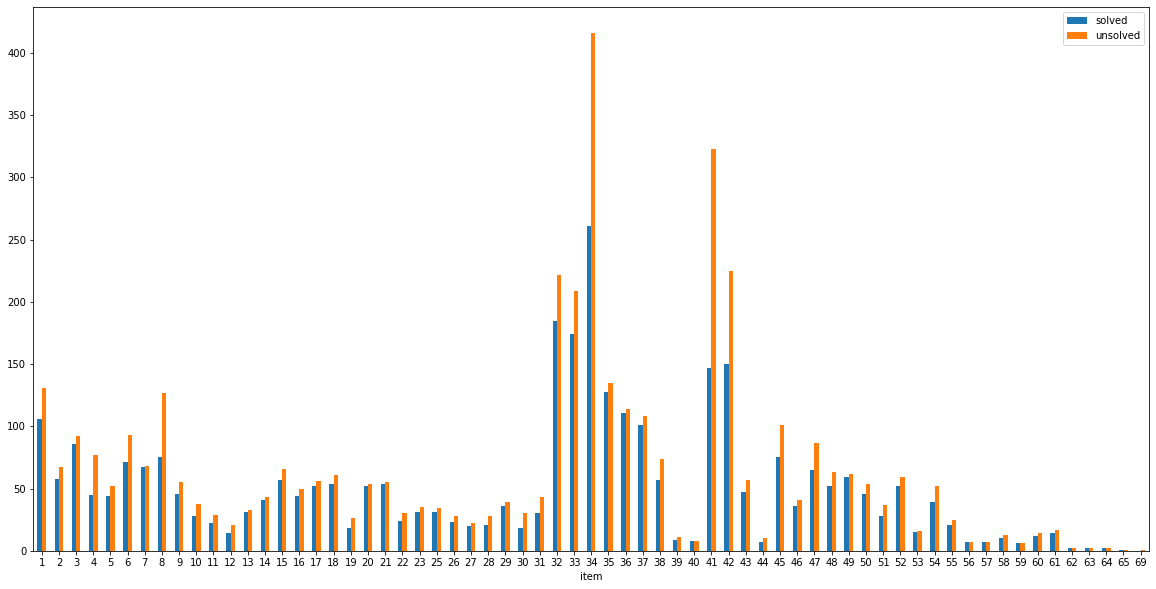

<IPython.core.display.Javascript object>

In [12]:
tmp = ip_item_log_frame[["item", "solved"]].groupby("item").sum()
tmp["unsolved"] = ip_item_log_frame.item.value_counts().sort_index()
tmp.plot.bar(rot=0, figsize=(20, 10))
plt.show()

In [13]:
exc = []


def decode_solution(solution):
    code = eval(solution)[0][1]
    return code


def decode_code(code):
    try:
        code = b64decode(code).decode("utf-8")
        tree = ast.parse(code)

        return astunparse.unparse(tree).strip()
    except Exception as e:
        exc.append(type(e))
        return ""


def parse_ast(code):
    try:
        tree = ast.parse(code)
        tree = NormFunctions(func=None).visit(tree)
        tree = NormIdentifiers().visit(tree)

        return astunparse.unparse(tree).strip()
    except Exception as e:
        exc.append(type(e))
        return ""

<IPython.core.display.Javascript object>

In [14]:
ip_log_frame["dec_answer"] = ip_log_frame.answer.apply(decode_code)
ip_log_frame["ast_clean"] = ip_log_frame["dec_answer"].apply(parse_ast)
ip_log_frame = ip_log_frame[
    (ip_log_frame["dec_answer"] != "") & (ip_log_frame["ast_clean"] != "")
]

<IPython.core.display.Javascript object>

In [15]:
Counter(exc)

Counter({binascii.Error: 1330,
         UnicodeDecodeError: 290,
         ValueError: 8,
         SyntaxError: 3039,
         TypeError: 28,
         IndentationError: 699,
         TabError: 2035,
         MemoryError: 2})

<IPython.core.display.Javascript object>

In [16]:
cols = ["id", "item", "correct", "dec_answer", "ast_clean"]
code_frame = ip_log_frame[cols]
code_frame["dec_len"] = code_frame["dec_answer"].apply(len)
code_frame["clean_len"] = code_frame["ast_clean"].apply(len)
code_frame.head()

,id,item,correct,dec_answer,ast_clean,dec_len,clean_len
428,1979,31,0,def find_longest_word(words_list):\n break,def function0(arg0):\n break,44,30
429,1980,31,0,def find_longest_word(words_list):\n break,def function0(arg0):\n break,44,30
430,1981,31,0,def find_longest_word(words_list):\n break,def function0(arg0):\n break,44,30
431,1982,31,0,def find_longest_word(words_list):\n break,def function0(arg0):\n break,44,30
432,1983,31,0,def find_longest_word(words_list):\n break,def function0(arg0):\n break,44,30


<IPython.core.display.Javascript object>

In [17]:
ip_item_frame["dec_solution"] = (
    ip_item_frame["solution"].apply(decode_solution).apply(decode_code)
)
ip_item_frame["ast_clean"] = ip_item_frame["dec_solution"].apply(parse_ast)

<IPython.core.display.Javascript object>

In [18]:
solutions_frame = ip_item_frame[["id", "name", "dec_solution", "ast_clean"]]
solutions_frame.head()

,id,name,dec_solution,ast_clean
0,1,Výpis čísel,"def numbers(n):\n for i in range(1, (n + 1)...","def function0(arg0):\n for id_0 in id_1(1, ..."
1,2,Fibonacciho posloupnost,def fibonacci(n):\n current = 1\n next =...,def function0(arg0):\n id_0 = 1\n id_1 =...
2,3,Faktoriál,def factorial(n):\n value = 1\n for i in...,def function0(arg0):\n id_0 = 1\n for id...
3,4,Abeceda,def alphabet(n):\n for i in range(n):\n ...,def function0(arg0):\n for id_0 in id_1(id_...
4,5,Zdvojení znaků,def duplication(text):\n output = ''\n f...,def function0(arg0):\n id_0 = ''\n for i...


<IPython.core.display.Javascript object>

In [19]:
data_columns = ["dec_len", "clean_len"]

for _, row in tqdm(solutions_frame.iterrows(), total=solutions_frame.shape[0]):
    id = row["id"]
    ed_column = f"ed_{id:02d}"
    data_columns.append(ed_column)

    ed = np.array(
        [editdistance.eval(row["ast_clean"], code) for code in code_frame["ast_clean"]]
    )
    avg_len = (len(row["ast_clean"]) + code_frame["clean_len"]) / 2.0
    code_frame[ed_column] = 100.0 * (1.0 - (ed / avg_len))

    ed_column = f"edr_{id:02d}"
    data_columns.append(ed_column)

    ed = np.array(
        [
            editdistance.eval(row["dec_solution"], code)
            for code in code_frame["dec_answer"]
        ]
    )
    avg_len = (len(row["dec_solution"]) + code_frame["dec_len"]) / 2.0
    code_frame[ed_column] = 100.0 * (1.0 - (ed / avg_len))

<IPython.core.display.Javascript object>

In [20]:
code_frame.head()

,id,item,correct,dec_answer,ast_clean,dec_len,clean_len,ed_01,edr_01,ed_02,...,ed_70,edr_70,ed_71,edr_71,ed_72,edr_72,ed_73,edr_73,ed_74,edr_74
428,1979,31,0,def find_longest_word(words_list):\n break,def function0(arg0):\n break,44,30,-4.273504,1.666667,-41.666667,...,-35.672515,-26.086957,-42.857143,-35.545024,-51.515152,-37.815126,-61.744966,-52.447552,-71.06599,-60.433604
429,1980,31,0,def find_longest_word(words_list):\n break,def function0(arg0):\n break,44,30,-4.273504,1.666667,-41.666667,...,-35.672515,-26.086957,-42.857143,-35.545024,-51.515152,-37.815126,-61.744966,-52.447552,-71.06599,-60.433604
430,1981,31,0,def find_longest_word(words_list):\n break,def function0(arg0):\n break,44,30,-4.273504,1.666667,-41.666667,...,-35.672515,-26.086957,-42.857143,-35.545024,-51.515152,-37.815126,-61.744966,-52.447552,-71.06599,-60.433604
431,1982,31,0,def find_longest_word(words_list):\n break,def function0(arg0):\n break,44,30,-4.273504,1.666667,-41.666667,...,-35.672515,-26.086957,-42.857143,-35.545024,-51.515152,-37.815126,-61.744966,-52.447552,-71.06599,-60.433604
432,1983,31,0,def find_longest_word(words_list):\n break,def function0(arg0):\n break,44,30,-4.273504,1.666667,-41.666667,...,-35.672515,-26.086957,-42.857143,-35.545024,-51.515152,-37.815126,-61.744966,-52.447552,-71.06599,-60.433604


<IPython.core.display.Javascript object>

In [21]:
transformed = []
scaler = StandardScaler()
scaled_data = scaler.fit_transform(code_frame[data_columns].values)
for method in tqdm(
    (
        PCA(random_state=42),
        make_pipeline(PCA(n_components=50, random_state=42), TSNE(random_state=42)),
        UMAP(random_state=42),
    )
):
    transformed.append(method.fit_transform(scaled_data))

<IPython.core.display.Javascript object>

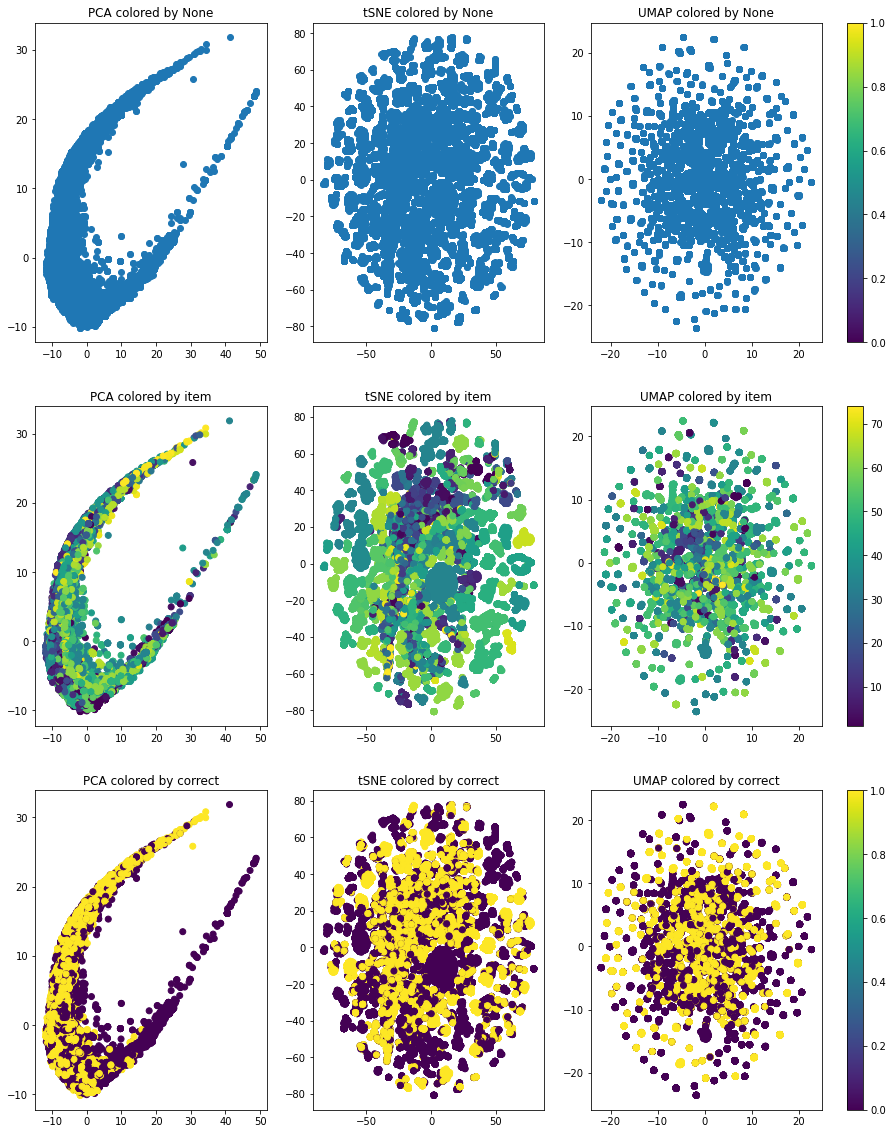

<IPython.core.display.Javascript object>

In [22]:
fig, axes = plt.subplots(3, 3, figsize=(15, 20))
for coloring, axs in zip((None, "item", "correct",), axes):
    for name, ax, trans in zip(("PCA", "tSNE", "UMAP"), axs, transformed):
        c = code_frame[coloring].values if coloring else None
        ax.set_title(f"{name} colored by {coloring}")
        im = ax.scatter(trans.T[0], trans.T[1], c=c)

    plt.colorbar(im, ax=axs, fraction=0.03, pad=0.03)

plt.show()